In [113]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

from scipy import stats
import imblearn
from imblearn.pipeline import Pipeline

import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, info_plots

In [114]:
df = pd.read_csv("../datasets/customer.csv")

In [115]:
df.shape

(10127, 21)

In [116]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [117]:
df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]

In [118]:
df = df.drop("clientnum", axis=1)

In [119]:
df.info()
# seems to be no null values: good.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   attrition_flag            10127 non-null  object 
 1   customer_age              10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   income_category           10127 non-null  object 
 7   card_category             10127 non-null  object 
 8   months_on_book            10127 non-null  int64  
 9   total_relationship_count  10127 non-null  int64  
 10  months_inactive_12_mon    10127 non-null  int64  
 11  contacts_count_12_mon     10127 non-null  int64  
 12  credit_limit              10127 non-null  float64
 13  total_revolving_bal       10127 non-null  int64  
 14  avg_op

In [120]:
df.describe()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [121]:
# before we do anything with the data, we should one-hot encode categorical variables
# first we have to extract the categorical variables

nums = df._get_numeric_data().columns
cats = list(set(df.columns) - set(nums))
print(cats)

['card_category', 'attrition_flag', 'income_category', 'gender', 'marital_status', 'education_level']


In [122]:
# we have a couple of choices with encoding here: can use one-hot, ordinal, or others
# ordinal would be good but the distance from blue to silver card may not be the same for silver to gold, for example
# we can use ordinal for income and maybe card, but for the others, one-hot is ideal
# however, with income, the "unknown" income may lead to trouble: how do we place the unknown?
# therefore, it may just be better to one-hot encode that as well, leaving out the unknown column

print(df["card_category"].value_counts())
print(df["income_category"].value_counts())

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: card_category, dtype: int64
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: income_category, dtype: int64


In [123]:
# can manually drop unknown and first columns later

for i in ['attrition_flag', 'income_category', 'gender', 'marital_status', 'education_level']:
    df = pd.concat([df,pd.get_dummies(df[i], prefix=i)], axis=1)
    df = df.drop(i, axis=1)

In [124]:
df.columns

Index(['customer_age', 'dependent_count', 'card_category', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt',
       'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio',
       'attrition_flag_Attrited Customer', 'attrition_flag_Existing Customer',
       'income_category_$120K +', 'income_category_$40K - $60K',
       'income_category_$60K - $80K', 'income_category_$80K - $120K',
       'income_category_Less than $40K', 'income_category_Unknown', 'gender_F',
       'gender_M', 'marital_status_Divorced', 'marital_status_Married',
       'marital_status_Single', 'marital_status_Unknown',
       'education_level_College', 'education_level_Doctorate',
       'education_level_Graduate', 'education_level_High School',
       'education_level_Post-Graduate', 'education_level_Uneducated',
       'education_level_Un

In [125]:
df.drop("education_level_Unknown", axis=1, inplace=True)
df.drop("marital_status_Unknown", axis=1, inplace=True)
df.drop("income_category_Unknown", axis=1, inplace=True)
df.drop("gender_F", axis=1, inplace=True)
df.drop("attrition_flag_Existing Customer", axis=1, inplace=True)
df = df.rename(columns={"attrition_flag_Attrited Customer": "attrited"})

In [126]:
card_mapping = {"Blue": 0, "Silver": 1, "Gold": 2, "Platinum": 3}
df["card"] = df["card_category"].replace(card_mapping)
df.drop("card_category", axis=1, inplace=True)

In [127]:
# now, we can continue standard analysis

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_age                    10127 non-null  int64  
 1   dependent_count                 10127 non-null  int64  
 2   months_on_book                  10127 non-null  int64  
 3   total_relationship_count        10127 non-null  int64  
 4   months_inactive_12_mon          10127 non-null  int64  
 5   contacts_count_12_mon           10127 non-null  int64  
 6   credit_limit                    10127 non-null  float64
 7   total_revolving_bal             10127 non-null  int64  
 8   avg_open_to_buy                 10127 non-null  float64
 9   total_amt_chng_q4_q1            10127 non-null  float64
 10  total_trans_amt                 10127 non-null  int64  
 11  total_trans_ct                  10127 non-null  int64  
 12  total_ct_chng_q4_q1             

In [128]:
# view correlations to the dependent variable
df.corr()["attrited"].sort_values(ascending=False)
# lots of variables, but very low correlations.

attrited                          1.000000
contacts_count_12_mon             0.204491
months_inactive_12_mon            0.152449
education_level_Doctorate         0.029386
income_category_Less than $40K    0.022466
marital_status_Single             0.019037
dependent_count                   0.018991
customer_age                      0.018203
months_on_book                    0.013687
education_level_Post-Graduate     0.011127
income_category_$120K +           0.009584
card                              0.002354
marital_status_Divorced           0.000850
avg_open_to_buy                  -0.000285
education_level_Uneducated       -0.001444
income_category_$80K - $120K     -0.003459
education_level_College          -0.007840
education_level_Graduate         -0.009046
income_category_$40K - $60K      -0.011688
education_level_High School      -0.011730
marital_status_Married           -0.023735
credit_limit                     -0.023873
income_category_$60K - $80K      -0.028221
gender_M   

In [129]:
corr = df.corr().abs().unstack().sort_values(ascending=False)
print(corr[corr != 1].head(20)[::2])

# some of the variables seem to be highly correlated, so we can remove some of these.
df.drop("credit_limit", axis=1, inplace=True)
df.drop("total_trans_ct", axis=1, inplace=True)
df.drop("customer_age", axis=1, inplace=True)

avg_open_to_buy        credit_limit                      0.995981
total_trans_ct         total_trans_amt                   0.807192
customer_age           months_on_book                    0.788912
marital_status_Single  marital_status_Married            0.741185
avg_utilization_ratio  total_revolving_bal               0.624022
gender_M               income_category_Less than $40K    0.580016
avg_utilization_ratio  avg_open_to_buy                   0.538808
card                   credit_limit                      0.492446
avg_open_to_buy        card                              0.489985
avg_utilization_ratio  credit_limit                      0.482965
dtype: float64


In [130]:
X = df.drop("attrited", axis=1)
y = df["attrited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

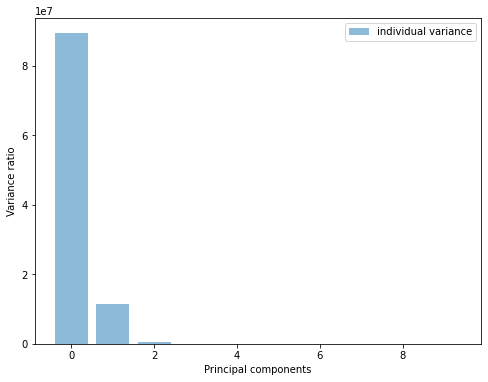

In [131]:
# Instead of removing features based on random forest elimination, let's use pca instead.

pca = PCA()
pca.fit_transform(X_test)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(10), pca_variance[:10], alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [132]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [133]:
kf = StratifiedKFold(n_splits=3)

def grid(name, model, params, pca=False):
    grid = RandomizedSearchCV(model, param_distributions=params, cv=kf, scoring='recall', n_jobs=-1)
    if pca:
        grid.fit(X_train_pca, y_train)
    else:
        grid.fit(X_train, y_train)
    return grid

In [134]:
dt_pca = DecisionTreeClassifier()
dt_params = {
    'max_depth': [100, 300, 600, None],
    "criterion": ["gini", "entropy"],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    "class_weight": [{0:1,1:3}, {0:1,1:4}]
}
dt_model_pca = grid("dt", dt, dt_params, True)
print(classification_report(dt_model_pca.predict(X_test_pca), y_test))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1581
           1       0.73      0.53      0.62       445

    accuracy                           0.85      2026
   macro avg       0.80      0.74      0.76      2026
weighted avg       0.85      0.85      0.85      2026



In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

dt = DecisionTreeClassifier()
dt_model = grid("dt", dt, dt_params)
print(classification_report(dt_model.predict(X_test), y_test))

# interstingly enough, the model seems to work better without using PCA. Let's try some more models.

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1613
           1       0.86      0.68      0.76       413

    accuracy                           0.91      2026
   macro avg       0.89      0.82      0.85      2026
weighted avg       0.91      0.91      0.91      2026



In [136]:
# random forest classifier

rf = RandomForestClassifier()
rf_params = {
    'bootstrap': [True, False],
    'max_depth': [100, 300, 600, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 300, 600],
    "class_weight": [{0:1,1:3}, {0:1,1:4}]
}
rf_model = grid("rf", rf, rf_params)
print(classification_report(rf_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1718
           1       0.82      0.87      0.85       308

    accuracy                           0.95      2026
   macro avg       0.90      0.92      0.91      2026
weighted avg       0.95      0.95      0.95      2026



In [140]:
lr_pca = LogisticRegression()
lr_params = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "penalty": ['l2', "none"],
    "C": [100, 10, 1.0, 0.1, 0.01],
}
lr_model_pca = grid("lr", lr_pca, lr_params, pca=True)
print(classification_report(lr_model_pca.predict(X_test_pca), y_test))

# Line search failing here; maybe logistic regression is not good with PCA in this case.

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      2026
           1       0.00      0.00      0.00         0

    accuracy                           0.84      2026
   macro avg       0.50      0.42      0.46      2026
weighted avg       1.00      0.84      0.91      2026



In [137]:
lr = LogisticRegression()
lr_params = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "penalty": ['l2', "none"],
    "C": [100, 10, 1.0, 0.1, 0.01],
}
lr_model = grid("lr", lr, lr_params)
print(classification_report(lr_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1842
           1       0.44      0.78      0.57       184

    accuracy                           0.89      2026
   macro avg       0.71      0.84      0.75      2026
weighted avg       0.93      0.89      0.90      2026



In [141]:
from sklearn.linear_model import RidgeClassifier

rc = RidgeClassifier()
rc_params = {
    "alpha": [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60],
    "normalize": [False, True]
}
rc_model = grid("rc", rc, rc_params)
print(classification_report(rc_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1937
           1       0.25      0.91      0.39        89

    accuracy                           0.88      2026
   macro avg       0.62      0.89      0.66      2026
weighted avg       0.96      0.88      0.91      2026



In [142]:
svc = LinearSVC()
svc_params = {
    "max_iter": [100, 300, 600, 1000, 1500],
    "C": [0.1, 1, 10],
    "class_weight": [{0:1,1:3}, {0:1,1:4}]
}
svc_model = grid("svc", svc, svc_params)
print(classification_report(svc_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1992
           1       0.10      0.91      0.17        34

    accuracy                           0.85      2026
   macro avg       0.55      0.88      0.55      2026
weighted avg       0.98      0.85      0.91      2026



In [143]:
gnb = GaussianNB()
gnb_params = {'var_smoothing': np.logspace(0,-9, num=100)}
gnb_model = grid("gnb", gnb, gnb_params)
print(classification_report(gnb_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1820
           1       0.42      0.67      0.52       206

    accuracy                           0.87      2026
   macro avg       0.69      0.78      0.72      2026
weighted avg       0.91      0.87      0.89      2026



In [144]:
per = Perceptron()
per_params = {
    "max_iter": [100, 300, 600, 1000, 1500],
    "eta0": [0.0001, 0.001, 0.01, 0.1, 1.0],
}
per_model = grid("per", per, per_params)
print(classification_report(per_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1465
           1       0.41      0.24      0.30       561

    accuracy                           0.69      2026
   macro avg       0.58      0.55      0.55      2026
weighted avg       0.65      0.69      0.66      2026



In [145]:
sgd = SGDClassifier()
sgd_params = {
    "loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    "penalty": ['l1', 'l2', 'elasticnet'],
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    "class_weight": [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
    "eta0": [1, 10, 100],
}
sgd_model = grid("sgd", sgd, sgd_params)
print(classification_report(sgd_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      2026
           1       0.00      0.00      0.00         0

    accuracy                           0.84      2026
   macro avg       0.50      0.42      0.46      2026
weighted avg       1.00      0.84      0.91      2026



In [146]:
# stacked classifier

estimators = [
    ("rf", rf),
    ("dt", dt),
    ("svc", svc),
    ("sgd", sgd),
    ("per", per),
    ("gnb", gnb),
    ("rc", rc),
]

stack = StackingClassifier(estimators, final_estimator=RandomForestClassifier(), cv=kf)
stack.fit(X_train, y_train)
X_pred = stack.predict(X_test)
print(confusion_matrix(X_pred, y_test))
print(classification_report(X_pred, y_test))

[[1670   67]
 [  31  258]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1737
           1       0.79      0.89      0.84       289

    accuracy                           0.95      2026
   macro avg       0.89      0.93      0.91      2026
weighted avg       0.95      0.95      0.95      2026



In [147]:
# xgboost
import xgboost
xgb = xgboost.XGBClassifier(use_label_encoder=False)
xgb_params = {
    'eta': [0.2,0.3,0.4],
    'max_depth': [5,6,7],
    'sampling_method': ['uniform','gradient_based'],
    'lambda': [1,1.5],
    'alpha': [0,0.5],
}
xgb_model = grid("xgb", xgb, xgb_params)
X_pred = xgb_model.predict(X_test)
print(confusion_matrix(X_pred, y_test))
print(classification_report(X_pred, y_test))

[16:21:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1675   39]
 [  26  286]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1714
           1       0.88      0.92      0.90       312

    accuracy                           0.97      2026
   macro avg       0.93      0.95      0.94      2026
weighted avg       0.97      0.97      0.97      2026



In [148]:
# xgboost
xgbt = xgboost.XGBRFClassifier(use_label_encoder=False)
xgbt_params = {
    "colsample_bynode": list(np.arange(0.1, 1.1, 0.1)),
    'max_depth': [100, 300, 600, None],
}
xgbt_model = grid("xgbt", xgbt, xgbt_params)
print(classification_report(xgbt_model.predict(X_test), y_test))

[16:21:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1741
           1       0.78      0.89      0.83       285

    accuracy                           0.95      2026
   macro avg       0.88      0.93      0.90      2026
weighted avg       0.95      0.95      0.95      2026



In [149]:
# random forest explanation: permutation importance
perm = PermutationImportance(rf_model).fit(X_test, y_test)
eli5.show_weights(perm)

Weight,Feature
0.3754 ± 0.0711,x8
0.1058 ± 0.0172,x5
0.0985 ± 0.0363,x9
0.0529 ± 0.0082,x7
0.0406 ± 0.0153,x3
0.0302 ± 0.0153,x6
0.0289 ± 0.0251,x2
0.0055 ± 0.0098,x4
0.0037 ± 0.0060,x1
0.0037 ± 0.0131,x16


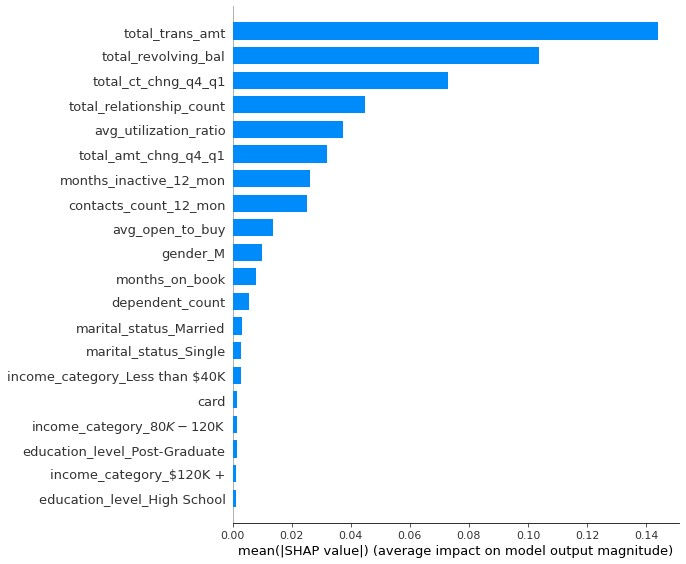

In [161]:
# random forest explainer: tree explainer and shap values
rf_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(rf_model.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [167]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][X_test.index[0]], X_test.iloc[0, :])

<AxesSubplot:>

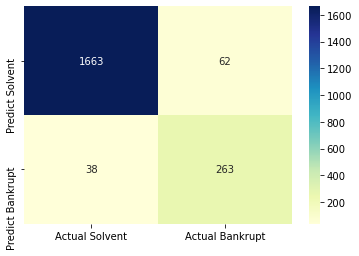

In [156]:
# random forest: heatmap
rf_pred = rf_model.predict(X_test)
cm = confusion_matrix(rf_pred, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Solvent', 'Actual Bankrupt'], index=['Predict Solvent', 'Predict Bankrupt'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

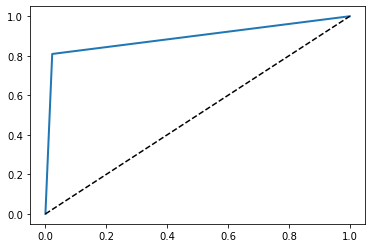

In [157]:
# random forest analysis: roc and auc with graphs

fpr, tpr, thresholds = roc_curve(y_test, rf_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.show()

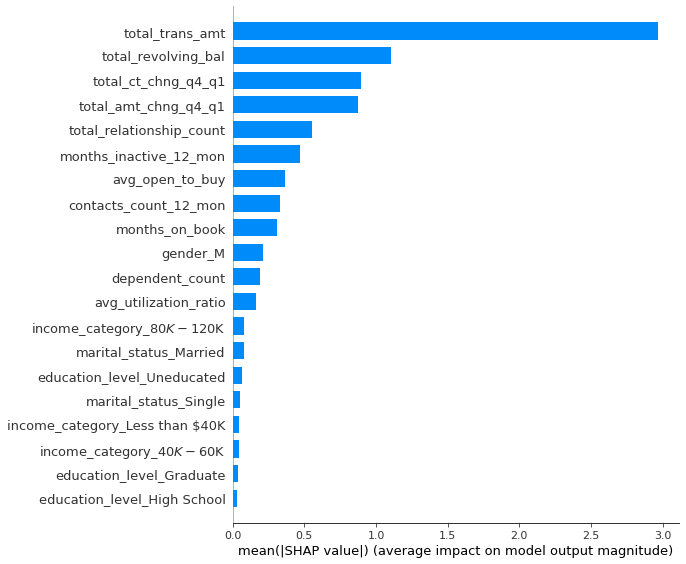

In [173]:
# random forest explainer: tree explainer and shap values
explainer = shap.TreeExplainer(xgb_model.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [179]:
shap_values

array([[-0.11492345, -0.8533147 , -0.20949665, ...,  0.0926725 ,
         0.0331631 , -0.00431916],
       [ 0.24413268,  0.19848235,  2.0411847 , ..., -0.01502842,
        -0.6119051 , -0.00262106],
       [ 0.02965578,  0.03300716, -0.01651284, ..., -0.02179126,
         0.02908468, -0.01231527],
       ...,
       [ 0.19452779, -0.26075685, -0.36125243, ..., -0.02637027,
        -0.29417902, -0.00671705],
       [ 0.13585624, -0.35142556,  1.1139021 , ..., -0.00574152,
         0.03782047, -0.00778167],
       [-0.0827239 ,  0.23050804, -0.37749964, ..., -0.01786071,
         0.0767858 , -0.00534928]], dtype=float32)

In [185]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])

<AxesSubplot:>

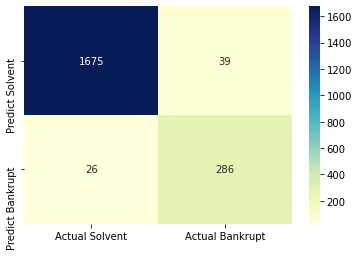

In [174]:
# best model analysis: heatmap
cm = confusion_matrix(X_pred, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Solvent', 'Actual Bankrupt'], index=['Predict Solvent', 'Predict Bankrupt'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

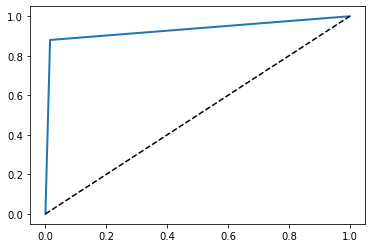

In [175]:
# best model analysis: roc and auc with graphs

fpr, tpr, thresholds = roc_curve(y_test, X_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.show()